## Dependencies

In [1]:
import pandas as pd
import numpy as np
import pickle
import math
import holidays
import gc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(17, 7))

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import catboost
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# label encoding
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_42/1790860163.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
def rmse(y, y_pred):
    return math.sqrt(mean_squared_error(y, y_pred))

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

## Reading data

In [4]:
# Reading all data files
data_dir = '/kaggle/input/competitive-data-science-predict-future-sales/'

sales        = pd.read_csv(data_dir + 'sales_train.csv', parse_dates=['date'], dayfirst=True, infer_datetime_format=True,)
items        = pd.read_csv(data_dir + 'items.csv') 
categories   = pd.read_csv(data_dir + 'item_categories.csv')
shops        = pd.read_csv(data_dir + 'shops.csv')
test         = pd.read_csv(data_dir + 'test.csv')
submit_sample= pd.read_csv(data_dir + 'sample_submission.csv')

## Preprocessing and Feature Generation

In [5]:
# we will only train using shops in train data that are in test data
test_shops = test["shop_id"].unique()
sales = sales[sales["shop_id"].isin(test_shops)]

print(f"# Unique Shops in Test Data:{len(test_shops)}\n# Unique Shops in Sales Data:{len(sales['shop_id'].unique())}")

# Unique Shops in Test Data:42
# Unique Shops in Sales Data:42


#### Any missing values?

In [6]:
sales.isnull().value_counts()

date   date_block_num  shop_id  item_id  item_price  item_cnt_day
False  False           False    False    False       False           2413246
Name: count, dtype: int64

#### shops

In [7]:
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
#similar city names
shops.loc[shops['shop_city'] =='!якутск', 'shop_city'] = 'якутск'
print(shops.head(5))
print('Unique Shop ID:', len(shops['shop_id'].unique()))
print('Unique Shop names:', len(shops['shop_name'].unique()))
print('Unique shop city:', len(shops['shop_city'].unique()))

                        shop_name  shop_id shop_city shop_type
0   !якутск орджоникидзе, 56 фран        0    якутск   NO_DATA
1   !якутск тц "центральный" фран        1    якутск        тц
2                адыгея тц "мега"        2    адыгея        тц
3  балашиха трк "октябрь-киномир"        3  балашиха       трк
4        волжский тц "волга молл"        4  волжский        тц
Unique Shop ID: 60
Unique Shop names: 60
Unique shop city: 31


#### Items

In [8]:
print('\n Unique item names:', len(items['item_name'].unique()))


 Unique item names: 22170


In [9]:
items['name_1'], items['name_2'] = items['item_name'].str.split('[', n=1, expand=True)
items['name_1'], items['name_3'] = items['item_name'].str.split('(', n=1, expand=True)

items['name_2'] = items['name_2'].astype(str).replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].astype(str).replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

In [10]:
items

,item_name,item_id,item_category_id,name_1,name_2,name_3
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,0,1,1
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,0,1,1
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,0,1,1
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,0,1,1
4,***КОРОБКА (СТЕКЛО) D,4,40,0,1,1
...,...,...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,0,1,1
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,0,1,1
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,0,1,1
22168,Яйцо для Little Inu,22168,62,0,1,1


In [11]:
from collections import Counter
from operator import itemgetter
import re

In [12]:
result_1 = Counter(' '.join(items['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature'])

print('Most common aditional features: \n\n', result)

Most common aditional features: 

 Empty DataFrame
Columns: [feature, count]
Index: []


In [13]:
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

items['item_name'] = items['item_name'].apply(lambda x: name_correction(x))
print(items.head())
print('Unique item names after correction:', len(items['item_name'].unique()))

                                       item_name  item_id  item_category_id  \
0                           во власти наваждения        0                40   
1  abbyy finereader 12 professional edition full        1                76   
2                                  в лучах славы        2                40   
3                                  голубая волна        3                40   
4                                        коробка        4                40   

   name_1 name_2 name_3  
0       0      1      1  
1       0      1      1  
2       0      1      1  
3       0      1      1  
4       0      1      1  
Unique item names after correction: 18121


#### Outliers

<Axes: xlabel='item_price'>

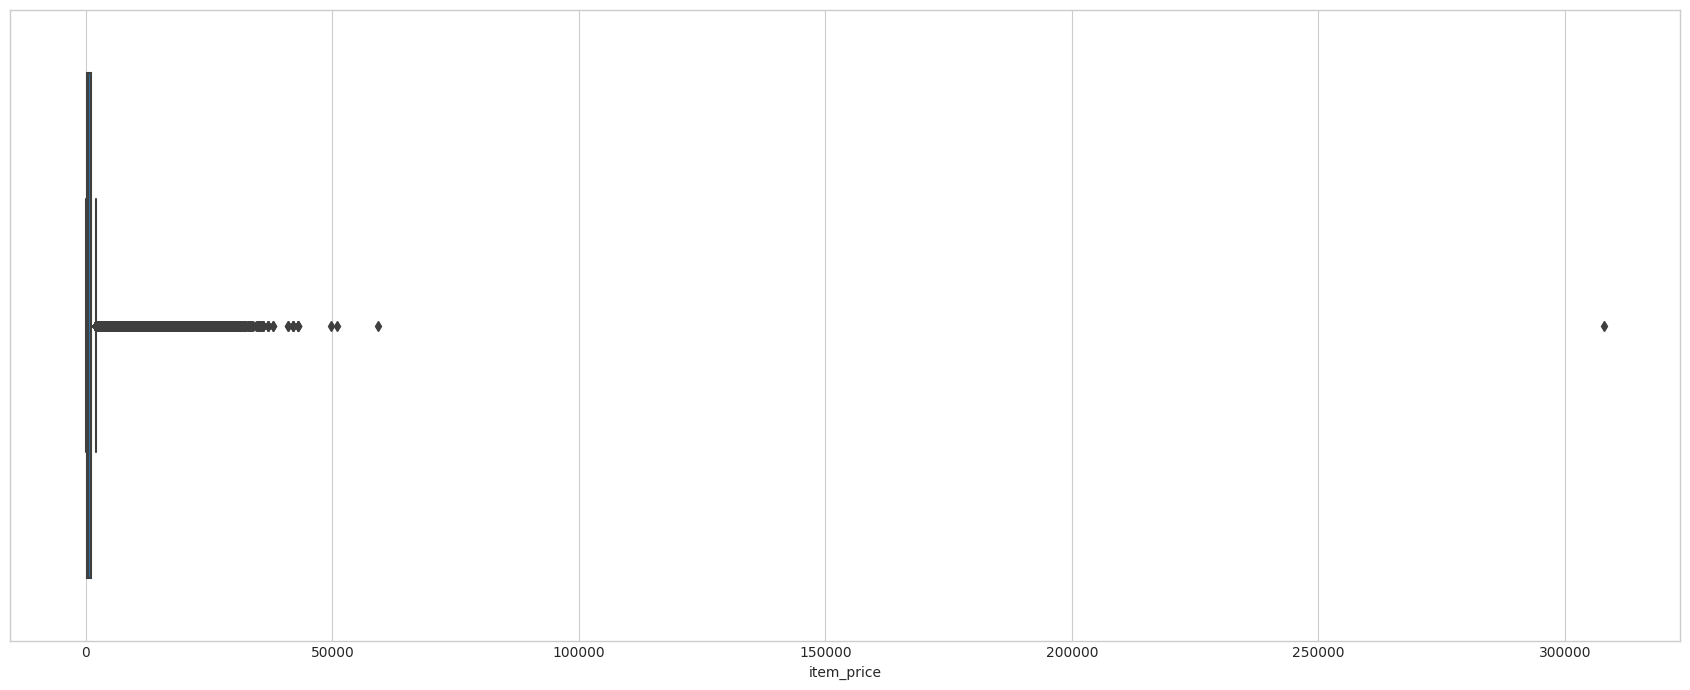

In [14]:
sns.boxplot(x=sales.item_price)

<Axes: xlabel='item_cnt_day'>

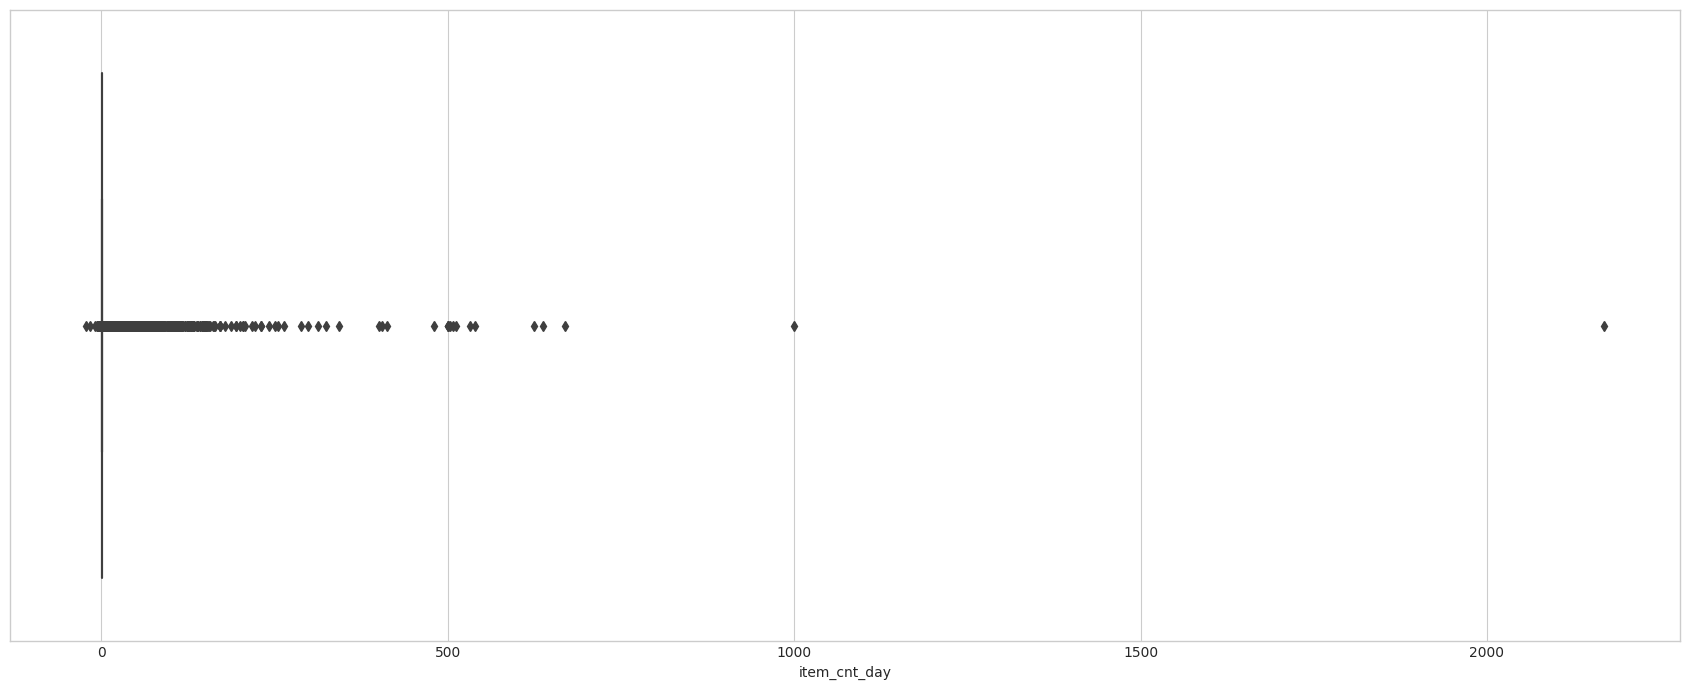

In [15]:
sns.boxplot(x=sales.item_cnt_day)

In [16]:
sales = sales[(sales.item_price < 50000) & (sales.item_price > 0)]
sales = sales[sales.item_cnt_day < 500]

#### Shops were found with almost the same name

Let's take a look

In [17]:
print(shops['shop_name'][0], '||', shops['shop_name'][57])
print(shops['shop_name'][1], '||', shops['shop_name'][58])
print(shops['shop_name'][10], '||', shops['shop_name'][11])
print(shops['shop_name'][39], '||', shops['shop_name'][40])

!якутск орджоникидзе, 56 фран || якутск орджоникидзе, 56
!якутск тц "центральный" фран || якутск тц "центральный"
жуковский ул. чкалова 39м? || жуковский ул. чкалова 39м²
ростовнадону трк "мегацентр горизонт" || ростовнадону трк "мегацентр горизонт" островной


This shops' name seem to be the same to each other. This could be possibly due to moving store locations, shops re-opening, or because of a typo. For instance, shop name “Жуковский ул. Чкалова 39м?” and “Жуковский ул. Чкалова 39м²” are more likly to be the same name, so those are being treated as the same shop name after pre-processing.

In [18]:
shops['shop_name'][0] = shops['shop_name'][57]
shops['shop_name'][1] = shops['shop_name'][58]
shops['shop_name'][10] = shops['shop_name'][11]
shops['shop_name'][39] = shops['shop_name'][40]

#### Adding the city in which the shop locates as a feature and other related features

it's been noticed that the first word in the shop_name string is the city where the shop locates

In [19]:
#extracting the city from the shop_name string
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
#similar city names
shops.loc[shops['city'] =='!якутск', 'city'] = 'якутск'
shops['city_enc'] = LabelEncoder().fit_transform(shops['city']).astype('int8')
shops.head()

,shop_name,shop_id,shop_city,shop_type,city,city_enc
0,"якутск орджоникидзе, 56",0,якутск,NO_DATA,якутск,29
1,"якутск тц ""центральный""",1,якутск,тц,якутск,29
2,"адыгея тц ""мега""",2,адыгея,тц,адыгея,0
3,"балашиха трк ""октябрь-киномир""",3,балашиха,трк,балашиха,1
4,"волжский тц ""волга молл""",4,волжский,тц,волжский,2


In [20]:
shops['city'].unique()

array(['якутск', 'адыгея', 'балашиха', 'волжский', 'вологда', 'воронеж',
       'выездная', 'жуковский', 'интернет-магазин', 'казань', 'калуга',
       'коломна', 'красноярск', 'курск', 'москва', 'мытищи', 'н.новгород',
       'новосибирск', 'омск', 'ростовнадону', 'спб', 'самара', 'сергиев',
       'сургут', 'томск', 'тюмень', 'уфа', 'химки', 'цифровой', 'чехов',
       'ярославль'], dtype=object)

#### Adding the category as a feature

In [21]:
#extracting the first word of the item_categories_name into category
categories['category'] = categories['item_category_name'].apply(lambda x: x.split()[0])  
categories['category_enc'] = LabelEncoder().fit_transform(categories['category'])
categories.head()

,item_category_name,item_category_id,category,category_enc
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1


In [22]:
categories['category'].value_counts()

category
Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: count, dtype: int64

In [23]:
# Cleaning Item Category Data
categories.loc[ (categories.category == "Игровые")| (categories.category == "Аксессуары"), "category" ] = "Игры"
category = []
for cat in categories.category.unique():
    if len(categories[categories.category == cat]) >= 5: 
        category.append( cat )
categories.category = categories.category.apply(lambda x: x if (x in category) else "etc")

the item_category_name contains the subtype and the code of every corresponding category

In [24]:
categories["split"] = categories.item_category_name.apply(lambda x: x.split("-"))
categories["subtype"] = categories.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories["subtype_code"] = LabelEncoder().fit_transform( categories["subtype"] )
categories.head()

,item_category_name,item_category_id,category,category_enc,split,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,etc,0,"[PC , Гарнитуры/Наушники]",Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,Игры,1,"[Аксессуары , PS2]",PS2,9
2,Аксессуары - PS3,2,Игры,1,"[Аксессуары , PS3]",PS3,10
3,Аксессуары - PS4,3,Игры,1,"[Аксессуары , PS4]",PS4,11
4,Аксессуары - PSP,4,Игры,1,"[Аксессуары , PSP]",PSP,13


#### Adding the date the product was first sold as a feature named first_sale_date

In [25]:
items['first_sale_date'] = sales.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)
items.head()

,item_name,item_id,item_category_id,name_1,name_2,name_3,first_sale_date
0,во власти наваждения,0,40,0,1,1,34.0
1,abbyy finereader 12 professional edition full,1,76,0,1,1,15.0
2,в лучах славы,2,40,0,1,1,34.0
3,голубая волна,3,40,0,1,1,34.0
4,коробка,4,40,0,1,1,34.0


#### Removing negative values from item_cnt after grouping them

In [26]:
item_total_cnt = sales.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum()
items_to_drop = item_total_cnt[item_total_cnt <= 0].index
sales = sales[~sales.set_index(['shop_id', 'item_id']).index.isin(items_to_drop)]
            
item_block_cnt = sales.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum()
items_to_drop = item_block_cnt[item_block_cnt <= 0].index
sales = sales[~sales.set_index(['date_block_num', 'shop_id', 'item_id']).index.isin(items_to_drop)]
     

In [27]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a matrix from all shops/items combinations from that month
matrix = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    matrix.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
matrix = pd.DataFrame(np.vstack(matrix), columns = index_cols,dtype=np.int32)
matrix.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2554,0
2,59,2555,0
3,59,2564,0
4,59,2565,0


In [28]:
temp = sales.groupby(index_cols).agg({'item_price'  : np.mean, 
                                      'item_cnt_day': np.sum})
temp.reset_index(inplace=True)
temp = temp.rename(columns={'item_cnt_day': 'item_cnt_month'})

In [29]:
all_data = pd.merge(matrix, temp, on=index_cols, how='left')
    
all_data['item_cnt_month'] = all_data['item_cnt_month'].astype('float32').fillna(0.).clip(0, 20)
all_data['item_price'] = all_data['item_price'].astype('float32').fillna(0.)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
all_data.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month
83613,2,19,0,0.0,0.0
85853,2,27,0,2499.0,1.0
88730,2,28,0,0.0,0.0
86782,2,29,0,0.0,0.0
83290,2,32,0,0.0,0.0


In [30]:
# Set date_block_num in test data to 34
test['date_block_num'] = 34

# Concatenate train and test
all_data = pd.concat([all_data, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=index_cols)
# Replace NaN with 0
all_data = all_data.fillna(0)

In [31]:
# Add column for count of items sold.

tmp = sales[sales['item_cnt_day'] > 0].groupby(index_cols).agg({'item_cnt_day': 'count'})
tmp.reset_index(inplace=True)
tmp = tmp.rename(columns={'item_cnt_day': 'item_rate_month'})
        
all_data = pd.merge(all_data, tmp, on=index_cols, how='left')
        
all_data['item_rate_month'] = all_data['item_rate_month'].astype('float32').fillna(0.)
   
gc.collect()
# Data downcasting
all_data = downcast_dtypes(all_data)

In [32]:
all_data.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month,item_rate_month
0,2,19,0,0.0,0.0,0.0
1,2,27,0,2499.0,1.0,1.0
2,2,28,0,0.0,0.0,0.0
3,2,29,0,0.0,0.0,0.0
4,2,32,0,0.0,0.0,0.0


In [33]:
group = all_data.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["avg_item_cnt_month"]
group.reset_index(inplace = True)

all_data = pd.merge(all_data, group, on = ["date_block_num"], how = "left")
all_data.date_avg_item_cnt = all_data["avg_item_cnt_month"].astype(np.float16)
all_data.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month,item_rate_month,avg_item_cnt_month
0,2,19,0,0.0,0.0,0.0,0.359925
1,2,27,0,2499.0,1.0,1.0,0.359925
2,2,28,0,0.0,0.0,0.0,0.359925
3,2,29,0,0.0,0.0,0.0,0.359925
4,2,32,0,0.0,0.0,0.0,0.359925


In [34]:
group = all_data.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['item_avg_item_cnt_month']
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num','item_id'], how='left')
all_data.item_avg_item_cnt_month = all_data['item_avg_item_cnt_month'].astype(np.float16)

In [35]:
group = all_data.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["shop_avg_item_cnt_month"]
group.reset_index(inplace = True)

all_data = pd.merge(all_data, group, on = ["date_block_num","shop_id"], how = "left")
all_data.shop_avg_item_cnt_month = all_data["shop_avg_item_cnt_month"].astype(np.float16)

In [36]:
group = all_data.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["shop_item_avg_item_cnt_month"]
group.reset_index(inplace = True)

all_data = pd.merge(all_data, group, on = ["date_block_num","shop_id","item_id"], how = "left")
all_data.shop_item_avg_item_cnt_month = all_data["shop_item_avg_item_cnt_month"].astype(np.float16)

In [37]:
# Data downcasting
all_data = downcast_dtypes(all_data)
all_data.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month,item_rate_month,avg_item_cnt_month,item_avg_item_cnt_month,shop_avg_item_cnt_month,shop_item_avg_item_cnt_month
0,2,19,0,0.0,0.0,0.0,0.359925,0.030304,0.153076,0.0
1,2,27,0,2499.0,1.0,1.0,0.359925,0.181763,0.153076,1.0
2,2,28,0,0.0,0.0,0.0,0.359925,0.242432,0.153076,0.0
3,2,29,0,0.0,0.0,0.0,0.359925,0.090881,0.153076,0.0
4,2,32,0,0.0,0.0,0.0,0.359925,5.332031,0.153076,0.0


In [38]:
shops['shop_type'] = LabelEncoder().fit_transform( shops['shop_type'])

In [39]:
# Merge other data
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(categories, on='item_category_id', how='left')

# Data downcasting
all_data = downcast_dtypes(all_data)
all_data.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month,item_rate_month,avg_item_cnt_month,item_avg_item_cnt_month,shop_avg_item_cnt_month,shop_item_avg_item_cnt_month,shop_name,shop_city,shop_type,city,city_enc,item_name,item_category_id,name_1,name_2,name_3,first_sale_date,item_category_name,category,category_enc,split,subtype,subtype_code
0,2,19,0,0.0,0.0,0.0,0.359925,0.030304,0.153076,0.0,"адыгея тц ""мега""",адыгея,5,адыгея,0,золотая коллекция м ф 72,40,0,1,1,0.0,Кино - DVD,Кино,7,"[Кино , DVD]",DVD,4
1,2,27,0,2499.0,1.0,1.0,0.359925,0.181763,0.153076,1.0,"адыгея тц ""мега""",адыгея,5,адыгея,0,007 legends,19,0,1,1,0.0,Игры - PS3,Игры,5,"[Игры , PS3]",PS3,10
2,2,28,0,0.0,0.0,0.0,0.359925,0.242432,0.153076,0.0,"адыгея тц ""мега""",адыгея,5,адыгея,0,007 legends,30,0,1,1,0.0,Игры PC - Стандартные издания,Игры,5,"[Игры PC , Стандартные издания]",Стандартные издания,55
3,2,29,0,0.0,0.0,0.0,0.359925,0.090881,0.153076,0.0,"адыгея тц ""мега""",адыгея,5,адыгея,0,007 legends,23,0,1,1,0.0,Игры - XBOX 360,Игры,5,"[Игры , XBOX 360]",XBOX 360,16
4,2,32,0,0.0,0.0,0.0,0.359925,5.332031,0.153076,0.0,"адыгея тц ""мега""",адыгея,5,адыгея,0,1 1,40,0,1,1,0.0,Кино - DVD,Кино,7,"[Кино , DVD]",DVD,4


In [40]:
group = all_data.groupby( ["date_block_num","city"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["city_avg_item_cnt_month"]
group.reset_index(inplace = True)

all_data = pd.merge(all_data, group, on = ["date_block_num","city"], how = "left")
all_data.city_avg_item_cnt_month = all_data["city_avg_item_cnt_month"].astype(np.float16)

In [41]:
group = all_data.groupby( ["date_block_num","city",'item_id'] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["item_city_avg_item_cnt_month"]
group.reset_index(inplace = True)

all_data = pd.merge(all_data, group, on = ["date_block_num","city", 'item_id'], how = "left")
all_data.item_city_avg_item_cnt_month = all_data["item_city_avg_item_cnt_month"].astype(np.float16)

In [42]:
group = all_data.groupby( ['item_id'] ).agg({"item_price" : ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

all_data = pd.merge(all_data, group, on = ['item_id'], how = "left")
all_data.item_avg_item_price = all_data["item_avg_item_price"].astype(np.float16)

In [43]:
group = all_data.groupby( ['date_block_num','item_id'] ).agg({"item_price" : ["mean"]})
group.columns = ["item_avg_item_price_month"]
group.reset_index(inplace = True)

all_data = pd.merge(all_data, group, on = ['date_block_num','item_id'], how = "left")
all_data.item_avg_item_price_month = all_data["item_avg_item_price_month"].astype(np.float16)

In [44]:
all_data.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month,item_rate_month,avg_item_cnt_month,item_avg_item_cnt_month,shop_avg_item_cnt_month,shop_item_avg_item_cnt_month,shop_name,shop_city,shop_type,city,city_enc,item_name,item_category_id,name_1,name_2,name_3,first_sale_date,item_category_name,category,category_enc,split,subtype,subtype_code,city_avg_item_cnt_month,item_city_avg_item_cnt_month,item_avg_item_price,item_avg_item_price_month
0,2,19,0,0.0,0.0,0.0,0.359925,0.030304,0.153076,0.0,"адыгея тц ""мега""",адыгея,5,адыгея,0,золотая коллекция м ф 72,40,0,1,1,0.0,Кино - DVD,Кино,7,"[Кино , DVD]",DVD,4,0.153076,0.0,0.848633,0.848633
1,2,27,0,2499.0,1.0,1.0,0.359925,0.181763,0.153076,1.0,"адыгея тц ""мега""",адыгея,5,адыгея,0,007 legends,19,0,1,1,0.0,Игры - PS3,Игры,5,"[Игры , PS3]",PS3,10,0.153076,1.0,95.562500,436.000000
2,2,28,0,0.0,0.0,0.0,0.359925,0.242432,0.153076,0.0,"адыгея тц ""мега""",адыгея,5,адыгея,0,007 legends,30,0,1,1,0.0,Игры PC - Стандартные издания,Игры,5,"[Игры PC , Стандартные издания]",Стандартные издания,55,0.153076,0.0,36.125000,83.187500
3,2,29,0,0.0,0.0,0.0,0.359925,0.090881,0.153076,0.0,"адыгея тц ""мега""",адыгея,5,адыгея,0,007 legends,23,0,1,1,0.0,Игры - XBOX 360,Игры,5,"[Игры , XBOX 360]",XBOX 360,16,0.153076,0.0,59.093750,151.500000
4,2,32,0,0.0,0.0,0.0,0.359925,5.332031,0.153076,0.0,"адыгея тц ""мега""",адыгея,5,адыгея,0,1 1,40,0,1,1,0.0,Кино - DVD,Кино,7,"[Кино , DVD]",DVD,4,0.153076,0.0,104.437500,285.500000


In [45]:
all_data.drop(['shop_name','shop_city','city','item_name','item_category_name','category', 'split','subtype'],axis=1,inplace=True)
gc.collect()
all_data.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month,item_rate_month,avg_item_cnt_month,item_avg_item_cnt_month,shop_avg_item_cnt_month,shop_item_avg_item_cnt_month,shop_type,city_enc,item_category_id,name_1,name_2,name_3,first_sale_date,category_enc,subtype_code,city_avg_item_cnt_month,item_city_avg_item_cnt_month,item_avg_item_price,item_avg_item_price_month
0,2,19,0,0.0,0.0,0.0,0.359925,0.030304,0.153076,0.0,5,0,40,0,1,1,0.0,7,4,0.153076,0.0,0.848633,0.848633
1,2,27,0,2499.0,1.0,1.0,0.359925,0.181763,0.153076,1.0,5,0,19,0,1,1,0.0,5,10,0.153076,1.0,95.562500,436.000000
2,2,28,0,0.0,0.0,0.0,0.359925,0.242432,0.153076,0.0,5,0,30,0,1,1,0.0,5,55,0.153076,0.0,36.125000,83.187500
3,2,29,0,0.0,0.0,0.0,0.359925,0.090881,0.153076,0.0,5,0,23,0,1,1,0.0,5,16,0.153076,0.0,59.093750,151.500000
4,2,32,0,0.0,0.0,0.0,0.359925,5.332031,0.153076,0.0,5,0,40,0,1,1,0.0,7,4,0.153076,0.0,104.437500,285.500000


In [46]:
def add_item_means(df, feature = None):
    item_mean_features = []
    print('Adding item means.......')
            
    if feature == None :
        group_items = ['date_block_num','item_id']
        feature = 'item_cnt'
    else:
        group_items = ['date_block_num','item_id'] + [feature]
                
    feature_mean_name = feature + '_mean'
                
    print('Adding item means for', feature, '...')
            
    df_tmp = df.groupby(group_items)['item_cnt_month'].mean()
    df_tmp = df_tmp.reset_index().rename(columns = {'item_cnt_month': feature_mean_name})
            
    df = pd.merge(df, df_tmp, on=group_items, how='left')
            
    item_mean_features.append(feature_mean_name)
            
    del df_tmp
    gc.collect()        
    return df, item_mean_features

In [47]:
def add_shop_means(df, feature):
    shop_mean_features = []
    print('Adding shop means.......')
            
    group_items = ['date_block_num', 'shop_id'] + [feature]
                
    feature_mean_name = feature + '_mean'
                
    print('Adding shop means for', feature, '...')
            
    df_tmp = df.groupby(group_items)['item_cnt_month'].mean()
    df_tmp = df_tmp.reset_index().rename(columns = {'item_cnt_month': feature_mean_name})
            
    df = pd.merge(df, df_tmp, on=group_items, how='left')
            
    shop_mean_features.append(feature)
            
    del df_tmp
    gc.collect()        
    return df, shop_mean_features

In [48]:
all_data, item_mean_features = add_item_means(all_data)
all_data, item_mean_features = add_item_means(all_data,'item_category_id')
all_data, shop_mean_features = add_shop_means(all_data,'city_enc')
# Data downcasting
all_data = downcast_dtypes(all_data)

Adding item means.......
Adding item means for item_cnt ...
Adding item means.......
Adding item means for item_category_id ...
Adding shop means.......
Adding shop means for city_enc ...


In [49]:
def add_shop_lags(df, feature_name, nlags, lag_names_to_clip ):
        
        mean_feature_name = feature_name + '_mean'
        
        print('Adding lags for', mean_feature_name, '...')
    
        df_tmp = df[['date_block_num', 'shop_id', feature_name, mean_feature_name]]
    
        for i in range(nlags, 0, -1):
        
            lag_feature_name = mean_feature_name + '_lag-' + str(i)
            lag_names_to_clip.append(lag_feature_name)
        
            df_shifted = df_tmp.copy()
            df_shifted.columns = ['date_block_num', 'shop_id', feature_name, lag_feature_name]
            df_shifted['date_block_num'] += i
            df = pd.merge(df, df_shifted.drop_duplicates(), on=['date_block_num', 'shop_id', feature_name], how='left')
            df[lag_feature_name] = df[lag_feature_name].fillna(0).astype('float32')
        
        del df_tmp
        del df_shifted
        gc.collect()
        return df, lag_names_to_clip
     

In [50]:
def add_item_lags(df, feature_name,nlags , lag_names_to_clip=[]):
        
        print('Adding item lags for', feature_name, '...')
        
    
        df_tmp = df[['date_block_num', 'shop_id', 'item_id', feature_name]]
    
        for i in range(nlags, 0, -1):
            lag_feature_name = feature_name +'_lag-' + str(i)
            lag_names_to_clip.append(lag_feature_name)
            df_shifted = df_tmp.copy()
            df_shifted.columns = ['date_block_num', 'shop_id', 'item_id', lag_feature_name]
            df_shifted['date_block_num'] += i
            df = pd.merge(df, df_shifted.drop_duplicates(), on=['date_block_num', 'shop_id', 'item_id'], how='left')
            
            df[lag_feature_name] = df[lag_feature_name].fillna(0).astype('float32')
        
        del df_tmp
        del df_shifted
        return df, lag_names_to_clip

In [51]:
nlags=3

all_data, lag_names_to_clip =  add_item_lags(all_data,'item_cnt_month', nlags)
# Data downcasting
all_data = downcast_dtypes(all_data)
all_data, lag_names_to_clip =  add_item_lags(all_data,'item_rate_month',nlags, lag_names_to_clip)
# Data downcasting
all_data = downcast_dtypes(all_data)
all_data, lag_names_to_clip =  add_item_lags(all_data,'item_price', nlags,lag_names_to_clip)
# Data downcasting
all_data = downcast_dtypes(all_data)

Adding item lags for item_cnt_month ...
Adding item lags for item_rate_month ...
Adding item lags for item_price ...


In [52]:
all_data, lag_names_to_clip =  add_item_lags(all_data,'avg_item_cnt_month',nlags, lag_names_to_clip)
all_data, lag_names_to_clip =  add_item_lags(all_data,'item_avg_item_cnt_month',nlags, lag_names_to_clip)
all_data, lag_names_to_clip =  add_item_lags(all_data,'shop_avg_item_cnt_month',nlags, lag_names_to_clip)
# Data downcasting
all_data = downcast_dtypes(all_data)
all_data, lag_names_to_clip =  add_item_lags(all_data,'shop_item_avg_item_cnt_month',nlags, lag_names_to_clip)
# Data downcasting
all_data = downcast_dtypes(all_data)
all_data, lag_names_to_clip =  add_item_lags(all_data,'city_avg_item_cnt_month',nlags, lag_names_to_clip)
all_data, lag_names_to_clip =  add_item_lags(all_data,'item_city_avg_item_cnt_month',nlags, lag_names_to_clip)
all_data, lag_names_to_clip =  add_item_lags(all_data,'item_avg_item_price_month',nlags, lag_names_to_clip)

# Data downcasting
all_data = downcast_dtypes(all_data)

Adding item lags for avg_item_cnt_month ...
Adding item lags for item_avg_item_cnt_month ...
Adding item lags for shop_avg_item_cnt_month ...
Adding item lags for shop_item_avg_item_cnt_month ...
Adding item lags for city_avg_item_cnt_month ...
Adding item lags for item_city_avg_item_cnt_month ...
Adding item lags for item_avg_item_price_month ...


In [53]:
lags = [1,2,3]
for i in lags:
    all_data["delta_price_lag_" + str(i) ] = (all_data["item_avg_item_price_month_lag-" + str(i)]- all_data["item_avg_item_price"] )/ all_data["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

all_data["delta_price_lag"] = all_data.apply(select_trends, axis = 1)
all_data["delta_price_lag"] = all_data.delta_price_lag.astype( np.float16 )
all_data["delta_price_lag"].fillna( 0 ,inplace = True)

In [54]:
features_to_drop = ["item_avg_item_price", "item_avg_item_price_month"]

for i in lags:
    features_to_drop.append("item_avg_item_price_month_lag-" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
all_data.drop(features_to_drop, axis = 1, inplace = True)
     

# Removing previously dropped lag items
remove = ['item_avg_item_price_month_lag-1','item_avg_item_price_month_lag-2','item_avg_item_price_month_lag-3']

for x in remove:
  lag_names_to_clip.remove(x)
lag_names_to_clip

['item_cnt_month_lag-3',
 'item_cnt_month_lag-2',
 'item_cnt_month_lag-1',
 'item_rate_month_lag-3',
 'item_rate_month_lag-2',
 'item_rate_month_lag-1',
 'item_price_lag-3',
 'item_price_lag-2',
 'item_price_lag-1',
 'avg_item_cnt_month_lag-3',
 'avg_item_cnt_month_lag-2',
 'avg_item_cnt_month_lag-1',
 'item_avg_item_cnt_month_lag-3',
 'item_avg_item_cnt_month_lag-2',
 'item_avg_item_cnt_month_lag-1',
 'shop_avg_item_cnt_month_lag-3',
 'shop_avg_item_cnt_month_lag-2',
 'shop_avg_item_cnt_month_lag-1',
 'shop_item_avg_item_cnt_month_lag-3',
 'shop_item_avg_item_cnt_month_lag-2',
 'shop_item_avg_item_cnt_month_lag-1',
 'city_avg_item_cnt_month_lag-3',
 'city_avg_item_cnt_month_lag-2',
 'city_avg_item_cnt_month_lag-1',
 'item_city_avg_item_cnt_month_lag-3',
 'item_city_avg_item_cnt_month_lag-2',
 'item_city_avg_item_cnt_month_lag-1']

In [55]:
for x in lag_names_to_clip:
  print(f'Feature {x}: Unique numbers are: {all_data[x].nunique()}')

Feature item_cnt_month_lag-3: Unique numbers are: 21
Feature item_cnt_month_lag-2: Unique numbers are: 21
Feature item_cnt_month_lag-1: Unique numbers are: 21
Feature item_rate_month_lag-3: Unique numbers are: 32
Feature item_rate_month_lag-2: Unique numbers are: 32
Feature item_rate_month_lag-1: Unique numbers are: 32
Feature item_price_lag-3: Unique numbers are: 31242
Feature item_price_lag-2: Unique numbers are: 32481
Feature item_price_lag-1: Unique numbers are: 33191
Feature avg_item_cnt_month_lag-3: Unique numbers are: 33
Feature avg_item_cnt_month_lag-2: Unique numbers are: 34
Feature avg_item_cnt_month_lag-1: Unique numbers are: 35
Feature item_avg_item_cnt_month_lag-3: Unique numbers are: 1912
Feature item_avg_item_cnt_month_lag-2: Unique numbers are: 1927
Feature item_avg_item_cnt_month_lag-1: Unique numbers are: 2037
Feature shop_avg_item_cnt_month_lag-3: Unique numbers are: 1002
Feature shop_avg_item_cnt_month_lag-2: Unique numbers are: 1022
Feature shop_avg_item_cnt_month_

In [56]:
idx = all_data[(all_data['item_price_lag-1'] == 0) & (all_data['item_price_lag-2'] != 0)].index
all_data.loc[idx, 'item_price_lag-1'] = all_data.loc[idx, 'item_price_lag-2']
idx = all_data[(all_data['item_price_lag-2'] == 0) & (all_data['item_price_lag-3'] != 0)].index
all_data.loc[idx, 'item_price_lag-2'] = all_data.loc[idx, 'item_price_lag-3']
        

In [57]:
all_data['lag_feature_mean'] = all_data[['item_cnt_month_lag-1', 
                                    'item_cnt_month_lag-2', 
                                    'item_cnt_month_lag-3']].mean(skipna=True, axis=1)
     
all_data["delta_price_lag"] = all_data["delta_price_lag"].replace([np.inf, -np.inf], np.nan).fillna(0.)
all_data.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_month,item_rate_month,avg_item_cnt_month,item_avg_item_cnt_month,shop_avg_item_cnt_month,shop_item_avg_item_cnt_month,shop_type,city_enc,item_category_id,name_1,name_2,name_3,first_sale_date,category_enc,subtype_code,city_avg_item_cnt_month,item_city_avg_item_cnt_month,item_cnt_mean,item_category_id_mean,city_enc_mean,item_cnt_month_lag-3,...,item_rate_month_lag-2,item_rate_month_lag-1,item_price_lag-3,item_price_lag-2,item_price_lag-1,avg_item_cnt_month_lag-3,avg_item_cnt_month_lag-2,avg_item_cnt_month_lag-1,item_avg_item_cnt_month_lag-3,item_avg_item_cnt_month_lag-2,item_avg_item_cnt_month_lag-1,shop_avg_item_cnt_month_lag-3,shop_avg_item_cnt_month_lag-2,shop_avg_item_cnt_month_lag-1,shop_item_avg_item_cnt_month_lag-3,shop_item_avg_item_cnt_month_lag-2,shop_item_avg_item_cnt_month_lag-1,city_avg_item_cnt_month_lag-3,city_avg_item_cnt_month_lag-2,city_avg_item_cnt_month_lag-1,item_city_avg_item_cnt_month_lag-3,item_city_avg_item_cnt_month_lag-2,item_city_avg_item_cnt_month_lag-1,delta_price_lag,lag_feature_mean
0,2,19,0,0.0,0.0,0.0,0.359925,0.030304,0.153076,0.0,5,0,40,0,1,1,0.0,7,4,0.153076,0.0,0.030303,0.030303,0.153065,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
1,2,27,0,2499.0,1.0,1.0,0.359925,0.181763,0.153076,1.0,5,0,19,0,1,1,0.0,5,10,0.153076,1.0,0.181818,0.181818,0.153065,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
2,2,28,0,0.0,0.0,0.0,0.359925,0.242432,0.153076,0.0,5,0,30,0,1,1,0.0,5,55,0.153076,0.0,0.242424,0.242424,0.153065,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
3,2,29,0,0.0,0.0,0.0,0.359925,0.090881,0.153076,0.0,5,0,23,0,1,1,0.0,5,16,0.153076,0.0,0.090909,0.090909,0.153065,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
4,2,32,0,0.0,0.0,0.0,0.359925,5.332031,0.153076,0.0,5,0,40,0,1,1,0.0,7,4,0.153076,0.0,5.333333,5.333333,0.153065,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0


In [58]:
noisy_shops = [25, 31, 42]
all_data['noisy_shop'] = all_data['shop_id'].isin(noisy_shops)

In [59]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_price', 'item_cnt_month',
       'item_rate_month', 'avg_item_cnt_month', 'item_avg_item_cnt_month',
       'shop_avg_item_cnt_month', 'shop_item_avg_item_cnt_month', 'shop_type',
       'city_enc', 'item_category_id', 'name_1', 'name_2', 'name_3',
       'first_sale_date', 'category_enc', 'subtype_code',
       'city_avg_item_cnt_month', 'item_city_avg_item_cnt_month',
       'item_cnt_mean', 'item_category_id_mean', 'city_enc_mean',
       'item_cnt_month_lag-3', 'item_cnt_month_lag-2', 'item_cnt_month_lag-1',
       'item_rate_month_lag-3', 'item_rate_month_lag-2',
       'item_rate_month_lag-1', 'item_price_lag-3', 'item_price_lag-2',
       'item_price_lag-1', 'avg_item_cnt_month_lag-3',
       'avg_item_cnt_month_lag-2', 'avg_item_cnt_month_lag-1',
       'item_avg_item_cnt_month_lag-3', 'item_avg_item_cnt_month_lag-2',
       'item_avg_item_cnt_month_lag-1', 'shop_avg_item_cnt_month_lag-3',
       'shop_avg_item_cnt_month_lag-

In [60]:
all_data.drop(['item_price','item_cnt_mean','city_enc_mean','item_category_id_mean','item_rate_month'],axis=1,inplace=True)
all_data.drop(['avg_item_cnt_month', 'item_avg_item_cnt_month', 'shop_avg_item_cnt_month',
       'shop_item_avg_item_cnt_month','city_avg_item_cnt_month', 'item_city_avg_item_cnt_month'],axis=1,inplace=True)

In [61]:
all_data.isna().sum()

shop_id                               0
item_id                               0
date_block_num                        0
item_cnt_month                        0
shop_type                             0
city_enc                              0
item_category_id                      0
name_1                                0
name_2                                0
name_3                                0
first_sale_date                       0
category_enc                          0
subtype_code                          0
item_cnt_month_lag-3                  0
item_cnt_month_lag-2                  0
item_cnt_month_lag-1                  0
item_rate_month_lag-3                 0
item_rate_month_lag-2                 0
item_rate_month_lag-1                 0
item_price_lag-3                      0
item_price_lag-2                      0
item_price_lag-1                      0
avg_item_cnt_month_lag-3              0
avg_item_cnt_month_lag-2              0
avg_item_cnt_month_lag-1              0


In [62]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8801351 entries, 0 to 8801350
Data columns (total 43 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   shop_id                             int32  
 1   item_id                             int32  
 2   date_block_num                      int32  
 3   item_cnt_month                      float32
 4   shop_type                           int32  
 5   city_enc                            int8   
 6   item_category_id                    int32  
 7   name_1                              int32  
 8   name_2                              object 
 9   name_3                              object 
 10  first_sale_date                     float32
 11  category_enc                        int32  
 12  subtype_code                        int32  
 13  item_cnt_month_lag-3                float32
 14  item_cnt_month_lag-2                float32
 15  item_cnt_month_lag-1                float32
 16  

In [63]:
all_data.drop(['name_1', 'name_2', 'name_3'],axis=1,inplace=True)

#### Adding the number of holidays in each month

In [64]:
all_data.loc[all_data['date_block_num'].isin( [0, 12, 24]), 'monthly_holidays']=8
all_data.loc[all_data['date_block_num'].isin( [1,2,5,10,13,14,17,22,25,26,29,34]), 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'].isin( [3,6,7,8,9,11,15,18,19,20,21,23,27,30,31,32,33]), 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'].isin( [4,16,28]), 'monthly_holidays']=2

In [65]:
all_data['new_arrival'] = all_data['first_sale_date'] == all_data['date_block_num']
all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)
all_data['month'] = all_data['date_block_num']%12

# Add number of days in each month to matrix df.
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data["days"] = all_data["month"].map(days).astype(np.int8)
# Data downcasting
all_data = downcast_dtypes(all_data) 

In [66]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,shop_type,city_enc,item_category_id,category_enc,subtype_code,item_cnt_month_lag-3,item_cnt_month_lag-2,item_cnt_month_lag-1,item_rate_month_lag-3,item_rate_month_lag-2,item_rate_month_lag-1,item_price_lag-3,item_price_lag-2,item_price_lag-1,avg_item_cnt_month_lag-3,avg_item_cnt_month_lag-2,avg_item_cnt_month_lag-1,item_avg_item_cnt_month_lag-3,item_avg_item_cnt_month_lag-2,item_avg_item_cnt_month_lag-1,shop_avg_item_cnt_month_lag-3,shop_avg_item_cnt_month_lag-2,shop_avg_item_cnt_month_lag-1,shop_item_avg_item_cnt_month_lag-3,shop_item_avg_item_cnt_month_lag-2,shop_item_avg_item_cnt_month_lag-1,city_avg_item_cnt_month_lag-3,city_avg_item_cnt_month_lag-2,city_avg_item_cnt_month_lag-1,item_city_avg_item_cnt_month_lag-3,item_city_avg_item_cnt_month_lag-2,item_city_avg_item_cnt_month_lag-1,delta_price_lag,lag_feature_mean,noisy_shop,monthly_holidays,new_arrival,duration_after_first_sale,month,days
0,2,19,0,0.0,5,0,40,7,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,False,8.0,True,0.0,0,31
1,2,27,0,1.0,5,0,19,5,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,False,8.0,True,0.0,0,31
2,2,28,0,0.0,5,0,30,5,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,False,8.0,True,0.0,0,31
3,2,29,0,0.0,5,0,23,5,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,False,8.0,True,0.0,0,31
4,2,32,0,0.0,5,0,40,7,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,False,8.0,True,0.0,0,31


In [67]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8801351 entries, 0 to 8801350
Data columns (total 44 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   shop_id                             int32  
 1   item_id                             int32  
 2   date_block_num                      int32  
 3   item_cnt_month                      float32
 4   shop_type                           int32  
 5   city_enc                            int8   
 6   item_category_id                    int32  
 7   category_enc                        int32  
 8   subtype_code                        int32  
 9   item_cnt_month_lag-3                float32
 10  item_cnt_month_lag-2                float32
 11  item_cnt_month_lag-1                float32
 12  item_rate_month_lag-3               float32
 13  item_rate_month_lag-2               float32
 14  item_rate_month_lag-1               float32
 15  item_price_lag-3                    float32
 16  

In [68]:
#save preprocessed-data as a pickle file
all_data.to_pickle('/kaggle/working/pickled_df.pkl')